# Current Issues: 

1.  Create best method for differencing and identifying differences between aligned neg image and pos image (denoise?)

2. Create best method for filtering out bad  match points  

In [1]:
from glob import glob 
import os
import numpy as np 
import pandas as pd
from scipy.stats import gaussian_kde
import cv2 
from skimage.measure import compare_ssim
import matplotlib.pyplot as plt 
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

[sift](https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html)

[docs](https://docs.opencv.org/2.4/modules/nonfree/doc/feature_detection.html?highlight=sift)

[feature matching](https://docs.opencv.org/3.3.0/dc/dc3/tutorial_py_matcher.html)

In [2]:
def hough_crop(rgb_img, debug = True): 
    '''
    Use Hough Circles to find the watch at the center of the image - prone to false positives. 
    Read more about the method here: https://www.docs.opencv.org/trunk/d4/d70/tutorial_hough_circle.html
    
    Parameters: 
    ----------
    rgb_img : (numpy array) image computed from absolute difference function 
    debug : (bool) if True, add the circles to the image to see why it failed. Can tune the Hough params accordingly. 
    
    Returns: 
    out : (numpy array) square image cropped using hough circles method 
    '''

    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    rows = gray.shape[0]
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 300,
                               param1=30, param2=40,
                               minRadius=50, maxRadius=200)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1])
            radius = i[2]
            if debug: 
                # circle center
                cv2.circle(gray, center, 1, (0, 100, 100), 3)
                # circle outline    
                cv2.circle(gray, center, radius, (255, 0, 255), 3)
                    
    out = gray[(center[1]-radius-20):(center[1]+radius+20),
               (center[0]-radius-20):(center[0]+radius+20) ]
    return out 

def center_crop(rgb_img): 
    '''
    Simple function to crop the center of the image where the watch is presumed to be. 
    Assumes that watch is close to center, fails silently if not. 
    
    Parameters: 
    ----------
    rgb_img : (numpy array) image computed from absolute difference function 
    
    Returns: 
    out : (numpy array) square image cropped using hough circles method 
    '''
    center = [int(x/2) for x in rgb_img.shape[:2]]
    cropped = rgb_img[(center[0]-80):(center[0]+80),
                      (center[1]-80):(center[1]+80)]
    return cropped



In [3]:
def debug_plot(img1,kp1,img2,kp2, data, df): 
    ########### Image ##############
    '''for debugging, draw our inliers (if successfully found the object) or matching keypoints (if failed).'''
    img = cv2.drawMatchesKnn(img1,kp1,img2,kp2,data,None, flags=2)
    plt.figure(figsize=(8, 8)); plt.title('All Found Key Points')
    plt.imshow(img)
    plt.show()
     
    ############## Plots ############ 
    '''plot some Prob. Density Functions of the SIFT theta and distances'''
    plt.figure(figsize=(22, 3))
    plt.subplot(1, 4, 1); plt.title('dist PDF')
    df.dist.plot('kde')
    
    plt.subplot(1, 4, 2); plt.title('theta PDF')
    df.theta.plot('kde')

    '''plot the translation vectors from SIFT to detect outliers'''
    plt.subplot(1, 4, 3)
    plt.title('SIFT Translation Vectors - color=theta')
    plt.xlabel('X loc')
    plt.ylabel('Y loc')
    for i in range(df.shape[0]):
        p = df.iloc[i]
        x = (p.srcX, p.dstX)
        y = (p.srcY, p.dstY)

        c1 = p.dist /np.max(df.dist)
        c2 = np.minimum(np.abs(p.theta), 3) / 3
        plt.plot(x, y, 'o-', c = [0, c2, 0], linewidth=1, markersize=3)
    
    '''outliers removed'''
    plt.subplot(1, 4, 4)
    plt.title('SIFT Translation Vectors - G=keep R=dont keep')
    plt.xlabel('X loc')
    plt.ylabel('Y loc')
    for i in range(df.shape[0]):
        p = df.iloc[i]
        x = (p.srcX, p.dstX)
        y = (p.srcY, p.dstY)

        if p.dist_within_std == False or p.theta_within_std==False:# p.DB == -1: 
            c = [1, 0, 0] #red - throw out 
        else:
            c = [0, 1, 0] #green - keep     
        plt.plot(x, y, 'o-', c =c, linewidth=1, markersize=3)
    plt.show()


In [4]:
def get_slope(x):
    '''get the slope between two points'''
    return (x.dstY - x.srcY) / (x.dstX - x.srcX)


def get_theta(x): 
    y = x.dstY - x.srcY
    x_ = x.dstX - x.srcX
    return np.arctan2(y, x_)


def get_dist(x):
    '''euclidian distance metric'''
    return np.sqrt((x.dstY-x.srcY)**2 + (x.dstX-x.srcX)**2)


def cluster(df, Detector):
    '''performing clustering with DBSCAN to detect outliers
    in the theta and distance fields '''
    df = Detector.match_points
    X = df  # [pd.Index(['dist', 'theta'])]
    X = StandardScaler().fit_transform(X)
    cluster = DBSCAN(eps=0.3, min_samples=10).fit(X)
    labels = cluster.labels_
    df['DB'] = labels
    return df


def within_normal(S, n=1):
    """
    Do a simple check to see if which values lie within 1 standard
    deviation of the mean for the distance and theta columns, respectively.
    Uses a psueo-mean - the point that is maximum on the probablity density
    function

    Arguments:
        S {pd.Series} -- a pandas Series of input data

    Keyword Arguments:
        n {int} -- is the number of standard deviations to be within
                    (default: {1})

    Returns:
        [pd.Series] --  a pandas Series of booleans where the data is within
                        the standard deviation
    """

    u = S[np.argmax(gaussian_kde(S).evaluate(S))]
    s = S.std()
    return (S < (u+s*n)) & (S > (u-s*n))


def normalize_img(img):
    '''normalizes an image'''

    norm = cv2.normalize(img, dst=False, alpha=0, beta=1,
                         norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return (norm * 255).astype(np.uint8)


class WatchErrorDetector():
    """
    The Detector Class - align and compute differences between images
    """

    def __init__(self, pos, neg, debug=False,
                 min_match_count=6, n_stds=0.8):

        self.IMG_SIZE = (1280, 1920)
        self.pos_img = normalize_img(cv2.resize(cv2.imread(pos, 1),
                                     self.IMG_SIZE))
        self.neg_img = normalize_img(cv2.resize(cv2.imread(neg, 1),
                                     self.IMG_SIZE))
        self.debug = debug

        # params for filtering SIFT matches
        self.MIN_MATCH_COUNT = min_match_count  # min number of SIFT matches
        self.n_stds = n_stds  # num of std. deviations for SIFT filtering

        self.pos_img_align = None  # aligned positive image
        self.low_rank = None  # low rank matrix from SVD (for differencing)
        self.diff_svd_img = None  # differencing using the SVD method
        self.diff_abs_img = None  # differencing using the absolute pixels

    def align_query_image(self):

        # read in gray scale images
        img1 = cv2.cvtColor(self.pos_img, cv2.COLOR_BGR2GRAY)  # queryImage
        img2 = cv2.cvtColor(self.neg_img, cv2.COLOR_BGR2GRAY)  # trainImage

        # find the keypoints and descriptors with SIFT
        sift = cv2.xfeatures2d.SIFT_create(0, 10, 0.03, 10, 1.4)
        kp1, des1 = sift.detectAndCompute(img1, None)
        kp2, des2 = sift.detectAndCompute(img2, None)

        # BFMatcher with default params
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)

        # Apply ratio test
        good = []  # this is for keypoints
        for i, mat in enumerate(matches):
            m, n = mat
            if m.distance < 0.75*n.distance:
                good.append([m])

        # If enough matches are found, we extract the locations of
        # matched keypoints in both the images.
        # But first we filter out the bad points.
        # Then they are passed to find the perpective transformation.
        # Once we get this 3x3 transformation matrix, we use it to transform
        # the corners of queryImage to corresponding points in trainImage.

        if len(good) > self.MIN_MATCH_COUNT:
            src_pts = np.float32([kp1[m[0].queryIdx].pt for m in good])\
                                .reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m[0].trainIdx].pt for m in good])\
                                .reshape(-1, 1, 2)

            # create a DataFrame of the points for filtering
            cols = ['srcX', 'srcY', 'dstX', 'dstY']
            self.match_points = np.hstack((src_pts.reshape(-1, 2),
                                           dst_pts.reshape(-1, 2),))
            self.match_points = pd.DataFrame(self.match_points,  columns=cols)
            self.match_points['slope'] = self.match_points.apply(get_slope, axis=1)
            self.match_points['dist'] = self.match_points.apply(get_dist, axis=1)
            self.match_points['theta'] = self.match_points.apply(get_theta, axis=1)

            # perform Clustering to segment the bad matches out
            self.match_points = cluster(self.match_points, self)
            self.match_points['dist_within_std'] = within_normal(self.match_points['dist'], self.n_stds)
            self.match_points['theta_within_std'] = within_normal(self.match_points['theta'], self.n_stds)

            # select only the good points, where DB == -1,
            # or within one standard deviation
            # good_matches = self.match_points[self.match_points.DB != -1]
            good_matches = self.match_points[(self.match_points.dist_within_std == True)
                                             & (self.match_points.theta_within_std == True)]
            src_pts = good_matches.loc[:, 'srcX':'srcY'].values.reshape(-1, 1, 2)
            dst_pts = good_matches.loc[:, 'dstX':'dstY'].values.reshape(-1, 1, 2)

            if self.debug:
                print('Total Matches: {} Good Matches: {}'
                      .format(len(self.match_points), len(good_matches)))

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            h, w = img1.shape
            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
            dst = cv2.perspectiveTransform(pts, M)

            img2 = cv2.polylines(img2, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)

        else:
            print("Not enough matches are found - %d/%d" % (len(good), self.MIN_MATCH_COUNT))

        if self.debug:
            debug_plot(img1, kp1, img2, kp2, good, df=self.match_points)

        # compute the image alignment from Homography Transform
        self.pos_img_align = cv2.warpPerspective(self.pos_img, M, self.pos_img.shape[:2][::-1])

        return 1

    def compute_difference(self, kernel_size=9, k=12):

        kernel = (kernel_size, kernel_size)
        img1 = cv2.GaussianBlur(cv2.cvtColor(self.pos_img_align, cv2.COLOR_BGR2GRAY), kernel, 1)
        img2 = cv2.GaussianBlur(cv2.cvtColor(self.neg_img, cv2.COLOR_BGR2GRAY), kernel, 1)

        # absolute diffence
        self.diff_abs_img = cv2.absdiff(img1, img2)

        # Singular Value Decomposition (SVD)
        U, s, V = np.linalg.svd(img2, full_matrices=False)
        self.low_rank = np.dot(U[:, :k], np.dot(np.diag(s[:k]), V[:k, :]))

        self.diff_svd_img = cv2.absdiff(self.low_rank.astype(np.uint8), img1)  # (img2 - self.low_rank)

        return 1
        

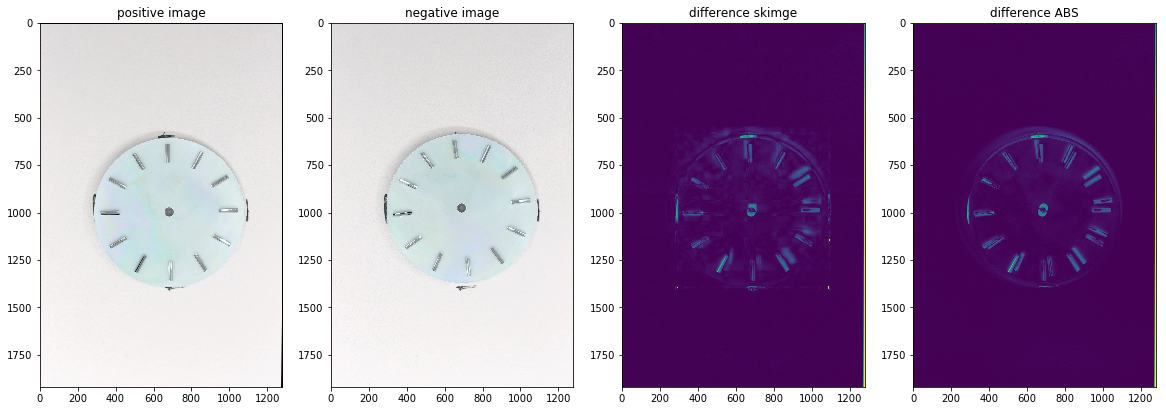

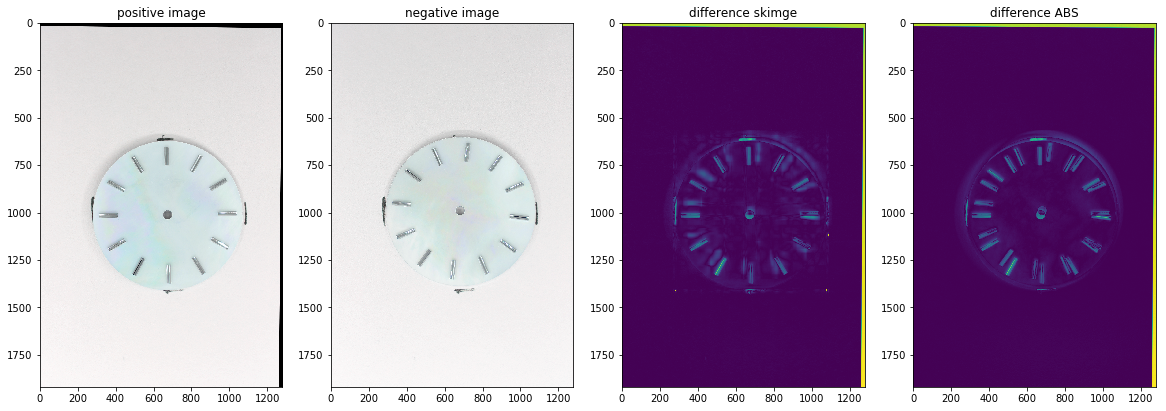

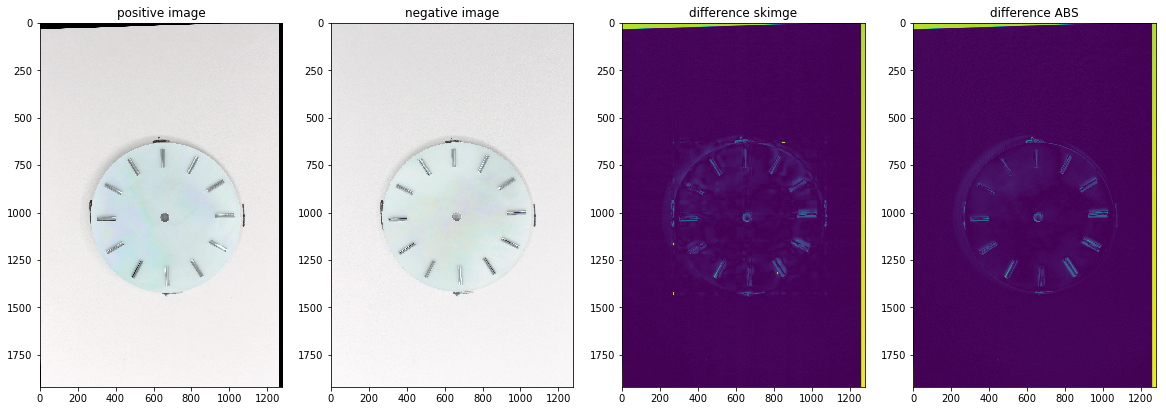

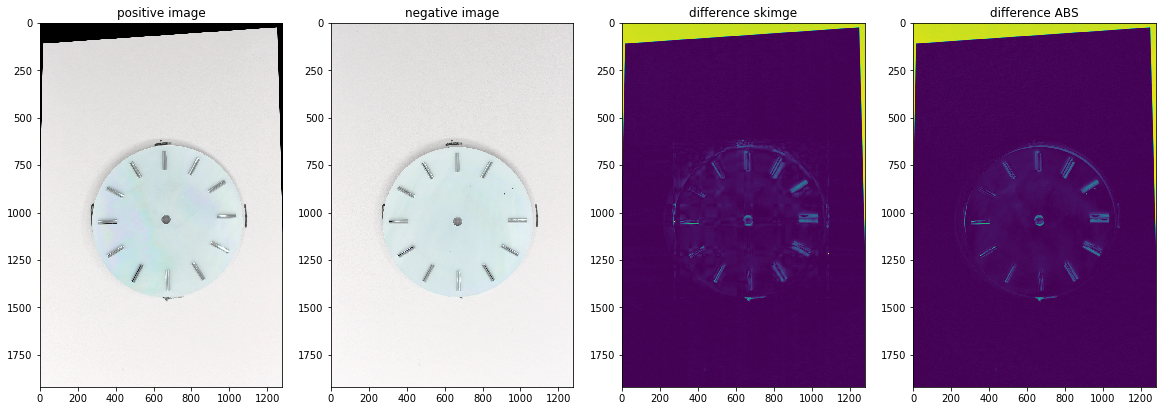

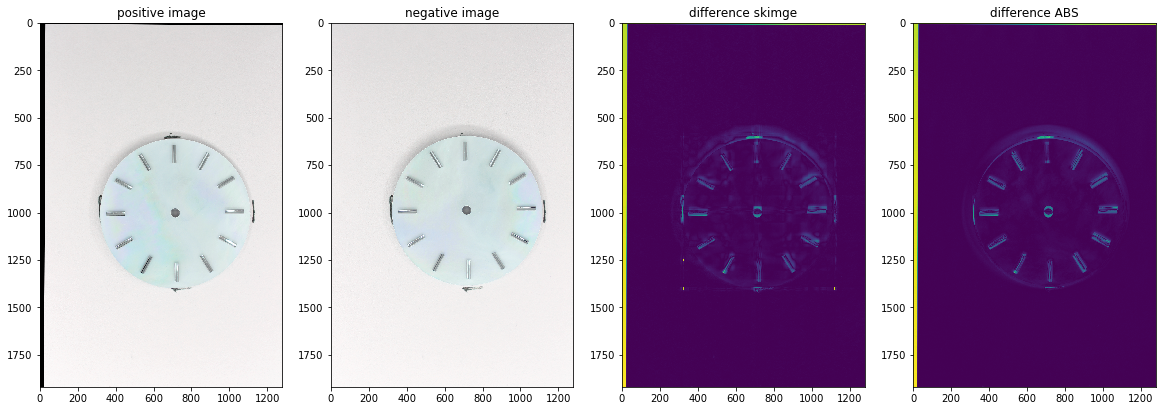

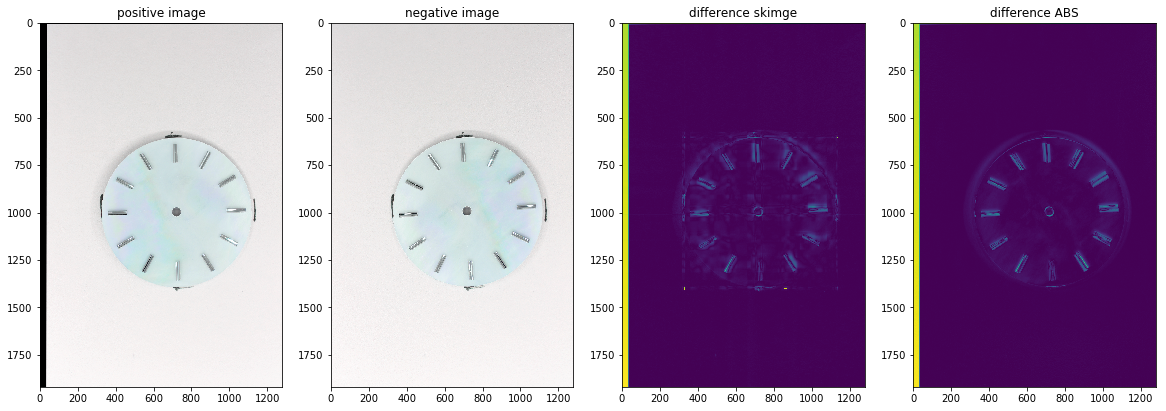

In [14]:
folder = str(10)

def na(x): return x
crop = na #center_crop #center_crop #crop method 

positives = glob('Sample {}/G/*'.format(folder))
negatives = glob('Sample {}/NG/*'.format(folder))
all_imgs = positives[1:] + negatives
 
#take one postive image, and iterate through the negatives 
for i, n in enumerate(positives[1:]): 
#     continue 
    
    Detector = WatchErrorDetector(positives[0], n, debug=False, n_stds=0.7)
    Detector.align_query_image()
    Detector.compute_difference()

    #visualize the results 
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 4, 1); plt.title('positive image')
    plt.imshow(crop(Detector.pos_img_align))

    plt.subplot(1, 4, 2); plt.title('negative image')
    plt.imshow(crop(Detector.neg_img))

    plt.subplot(1, 4, 3); plt.title('difference skimge')
    plt.imshow(crop(Detector.diff_svd_img))

    plt.subplot(1, 4, 4); plt.title('difference ABS')
    plt.imshow(crop(Detector.diff_abs_img))
    
    plt.savefig('pos-neg-{}.jpg'.format(i))

    plt.show()

In [20]:
# cv2.imwrite('pos.png', Detector.pos_img_align)
# cv2.imwrite('neg.png', Detector.neg_img)